In [3]:
import os
from os.path import dirname
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import seaborn as sns

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/SM_Figures/Fig_SM_static_loc_error"
nm_per_pixel = 117

- standard deviation of the position, representing static localization error.
- synchronize the mean position of each track to (0,0), then pool all spot coordinates together and get a 2D histogram, fit to a 2D Gaussian and find the sigma, which is the static localization error.
- calculate STD for each track, and filter out all moving tracks with STD > 200 nm because the ground truth is molecules are not moving and the "moving" molecules could be (1) binding-unbinding events, and (2) cluster of RNA that is too large and confuses our blob detector at d=3.

## Combine dataframes

In [4]:
os.chdir(folder_save)
lst_files = [f for f in os.listdir(".") if f.endswith(".csv")]

#### synchronize tracks to average position

In [5]:
x_sync = []
y_sync = []
for f in lst_files:
    df = pd.read_csv(f)
    trackids = list(df.trackID.unique())
    for idx in trackids:
        df_track = df[df.trackID == idx]
        try:
            x_nm = df_track.x.to_numpy(dtype=float) * nm_per_pixel
            y_nm = df_track.y.to_numpy(dtype=float) * nm_per_pixel
        except:
            print(f)
        meanx = x_nm.mean()
        meany = y_nm.mean()
        dx = x_nm - meanx
        dy = y_nm - meany
        singleRNA_std = np.sqrt(np.nanmean(dx**2 + dy**2))
        if singleRNA_std > 200:
            continue
        else:
            x_sync.extend(dx)
            y_sync.extend(dy)

# Plots

### bin the 2D distribution of x_sync and y_sync into 2D histogram and plot as heatmap

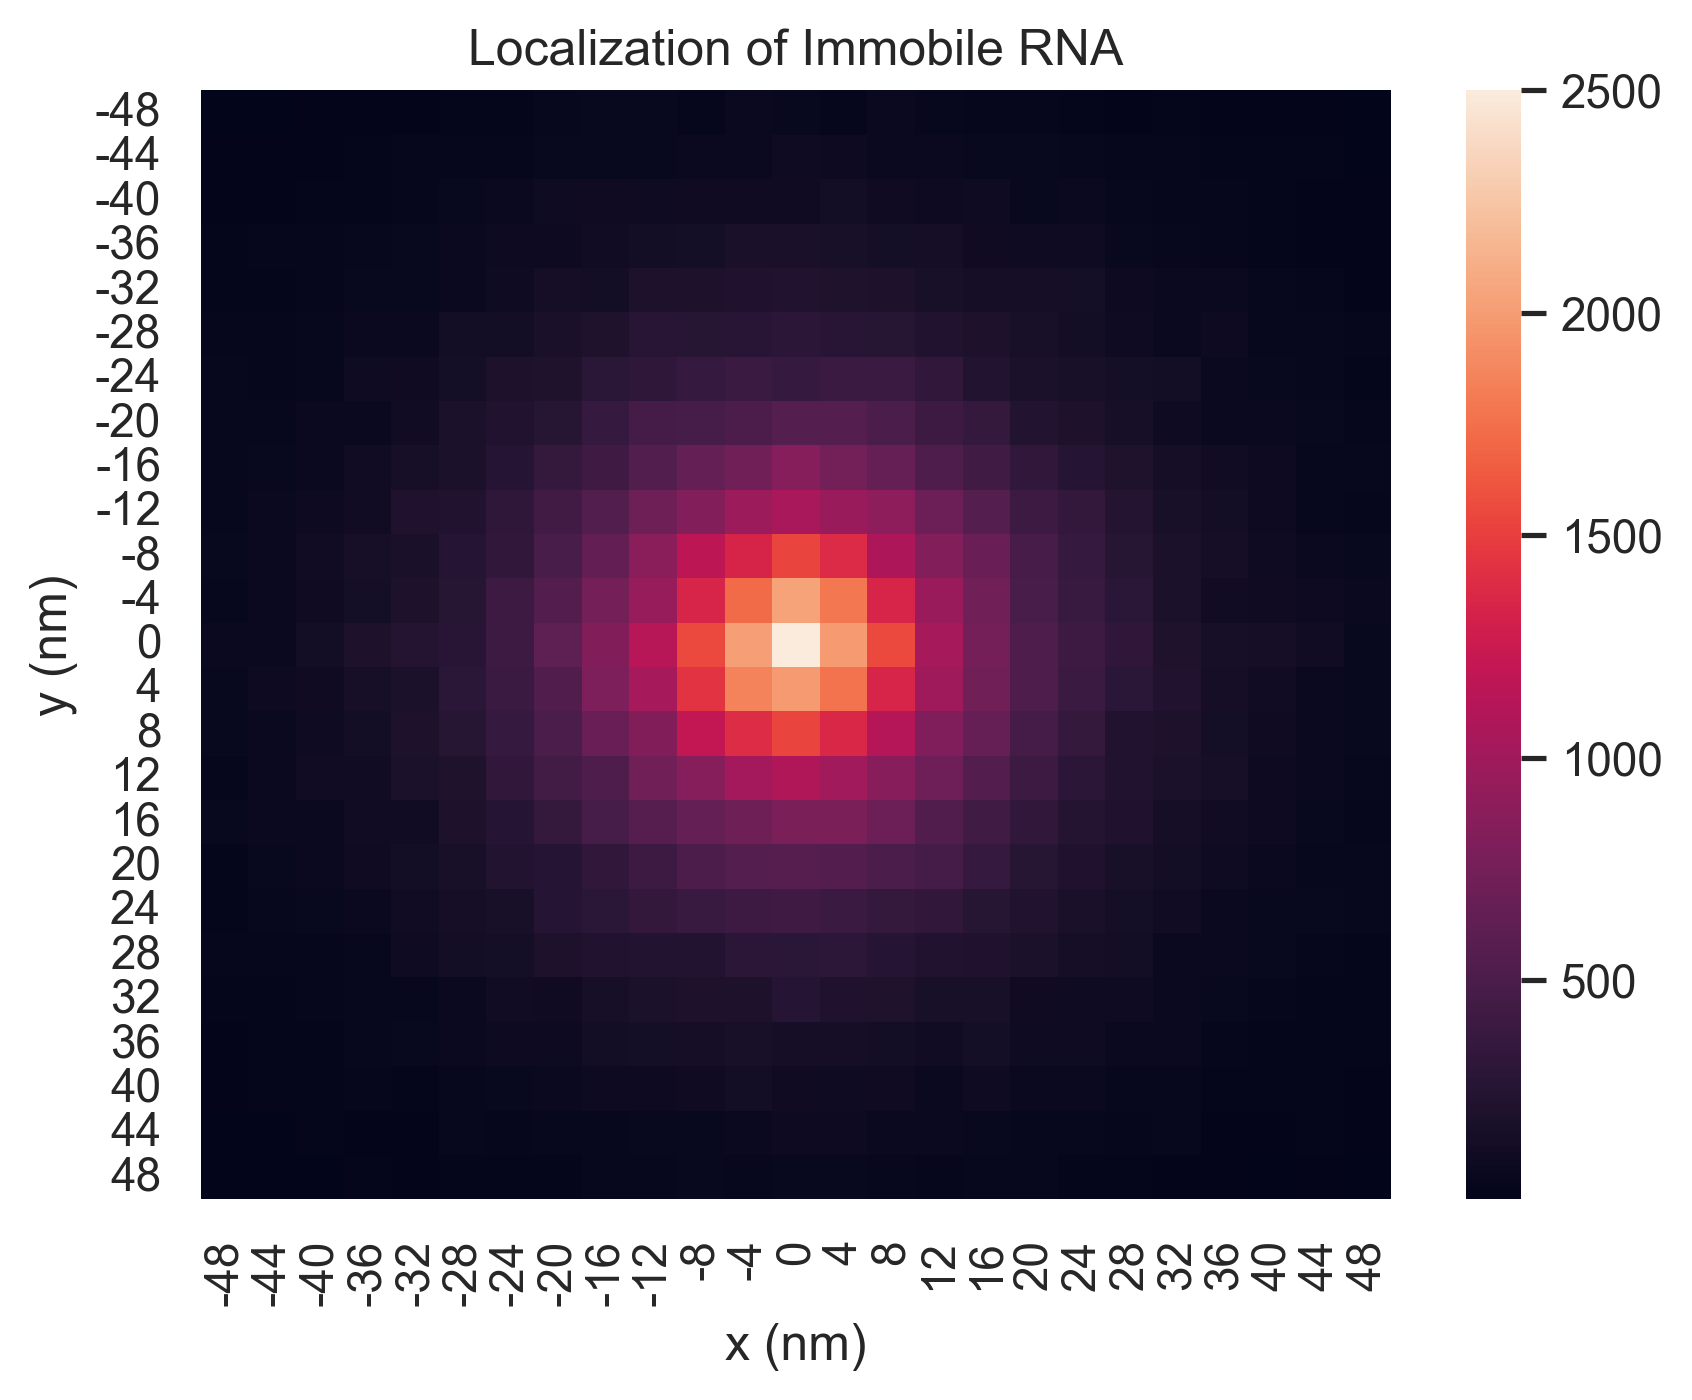

In [13]:
edges = np.arange(-50, 52, 4)
idx_center = round(len(edges) / 2) - 1
H, _, _ = np.histogram2d(x_sync, y_sync, bins=[edges, edges])

plt.figure(dpi=300)
ticks = (edges[1:] + edges[:-1]) / 2
ticks = ticks.astype(int)
sns.heatmap(H, xticklabels=ticks, yticklabels=ticks)
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.title("Localization of Immobile RNA")
plt.savefig("Localization of Immobile RNA.png", format="png", bbox_inches="tight")
plt.show()

### Localization error

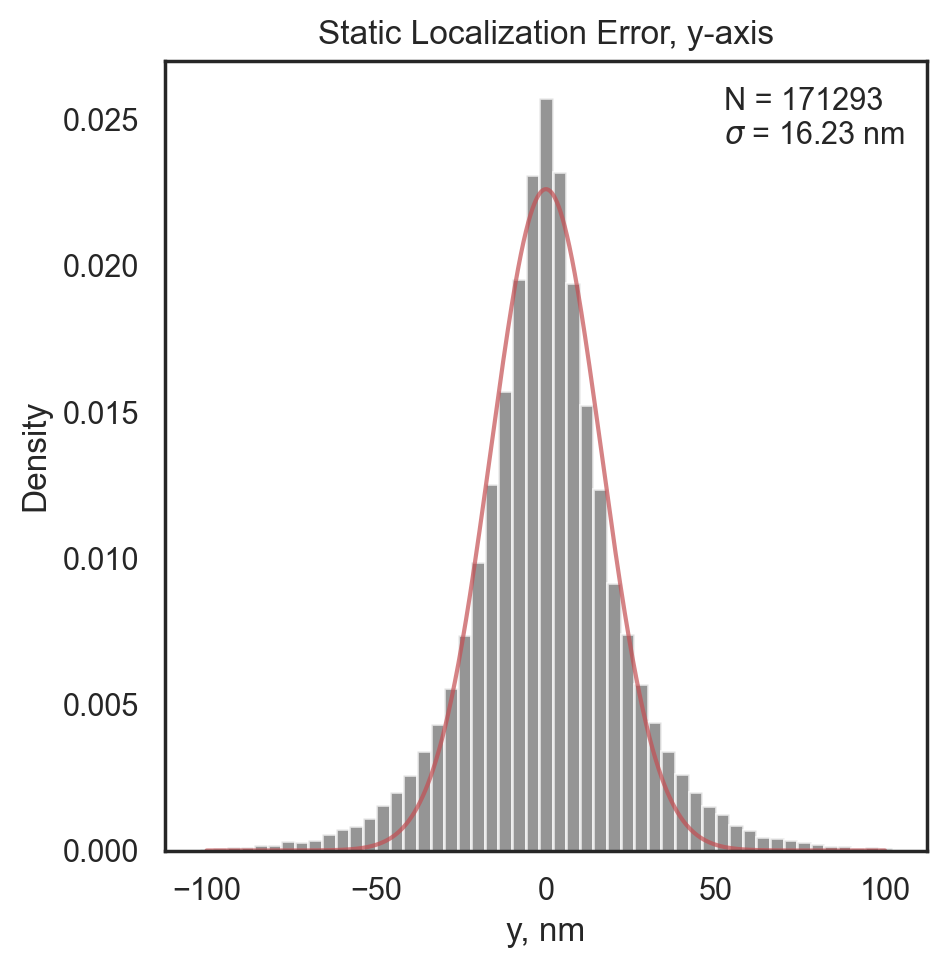

In [20]:
def Gauss_centered(x, A, sigma):
    return A * np.exp((-1 / 2) * ((x / sigma) ** 2))


edges = np.arange(-102, 104, 4)
ticks = (edges[1:] + edges[:-1]) / 2
ticks = ticks.astype(int)
plt.figure(figsize=(5, 5), dpi=200)
density, _, _ = plt.hist(y_sync, bins=edges, color="dimgray", alpha=0.7, density=True)
(A, sigma), covariance = curve_fit(Gauss_centered, ticks, density)
curve_x = np.arange(ticks[0], ticks[-1], 0.1)
curve_y = Gauss_centered(curve_x, A, sigma)
plt.plot(curve_x, curve_y, color=sns.color_palette()[3], alpha=0.7)
text = "N = " + str(len(y_sync)) + "\n" + "$\sigma$ = " + str(round(sigma, 2)) + " nm"
plt.text(
    0.74, 0.84, text, fontsize=11, transform=plt.gcf().transFigure,
)
plt.title("Static Localization Error, y-axis")
plt.xlabel("y, nm")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("Static Localization Error-y.png", format="png")
plt.show()

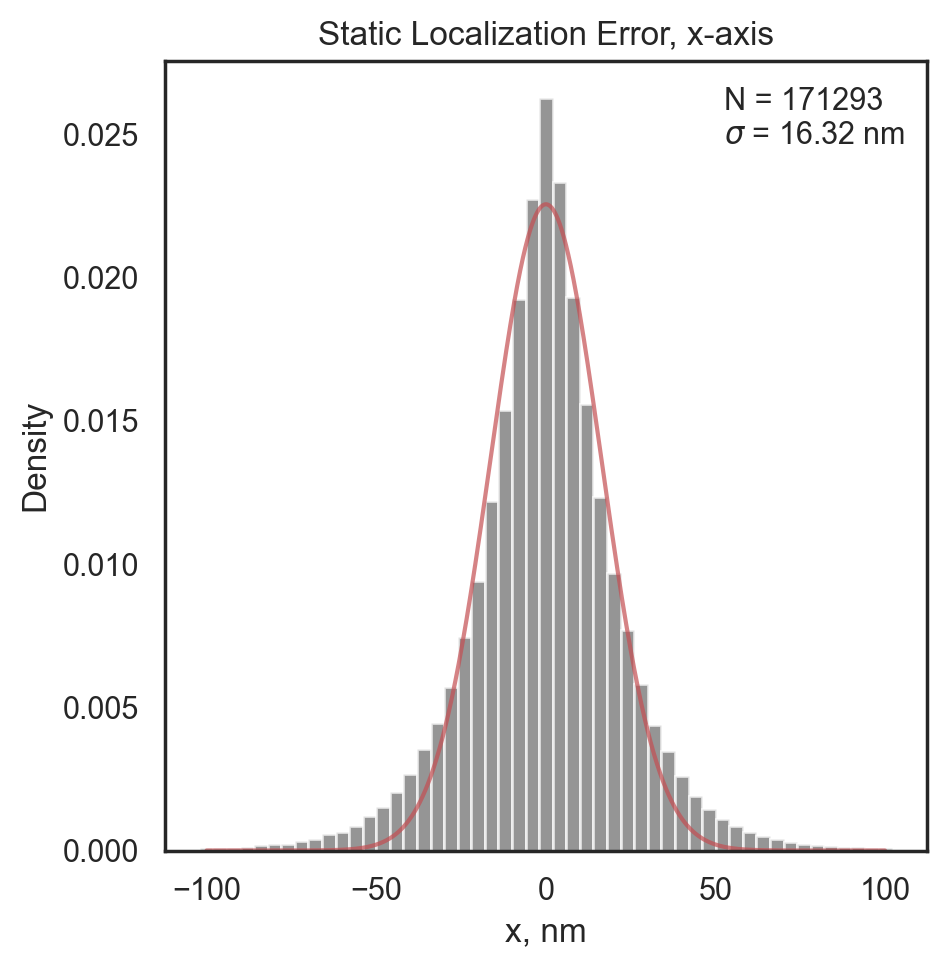

In [19]:
edges = np.arange(-102, 104, 4)
ticks = (edges[1:] + edges[:-1]) / 2
ticks = ticks.astype(int)
plt.figure(figsize=(5, 5), dpi=200)
density, _, _ = plt.hist(x_sync, bins=edges, color="dimgray", alpha=0.7, density=True)
(A, sigma), covariance = curve_fit(Gauss_centered, ticks, density)
curve_x = np.arange(ticks[0], ticks[-1], 0.1)
curve_y = Gauss_centered(curve_x, A, sigma)
plt.plot(curve_x, curve_y, color=sns.color_palette()[3], alpha=0.7)
text = "N = " + str(len(x_sync)) + "\n" + "$\sigma$ = " + str(round(sigma, 2)) + " nm"
plt.text(
    0.74, 0.84, text, fontsize=11, transform=plt.gcf().transFigure,
)
plt.title("Static Localization Error, x-axis")
plt.xlabel("x, nm")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("Static Localization Error-x.png", format="png")
plt.show()